In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn import grid_search
import requests
import json
from category import Category
from database import Database
from playlist import Playlist
from track import Track
from artist import Artist
from genre import Genre

from collections import Counter
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data Import And Processing

In [2]:
# Connect to database and load all playlist data
db = Database()
genresByPopularity = list(Genre.getByPopularity(db))
playlists = Playlist.loadAll(db)


In [3]:
# Get a list of all genres for all artists, frequency in the list
# indicates how many times those genres appear
def getAllGenres():
    genres = []
    for playlist in playlists:
        for track in playlist.tracks:
            if track.artist1:
                genres.extend(track.artist1.genres)
            if track.artist2:
                genres.extend(track.artist2.genres)
            if track.artist3:
                genres.extend(track.artist3.genres)
    return genres

# Remove all playlists containing "This is:" indicating that it features
# a single artist
def filterAllSingleArtist(playlists):
    multiArtistPlaylists = []
    for playlist in playlists:
        if 'this is:' not in playlist.name.decode('UTF-8').lower():
            multiArtistPlaylists.append(playlist)
    return multiArtistPlaylists

# Get a list of unique genres, sorted by their frequency
def genresByCount(allGenres):
    genresCount = Counter(allGenres)
    genresList = list(genresCount.items())
    # Sort the genres list by frequency
    genresList.sort(key=lambda x: -x[1])
    genres = [genre[0] for genre in genresList]
    # An empty string has been creeping into here
    if '' in genres:
        genres.remove('')
    return genres

# Get a list of all genres by frequency
genres = genresByCount(getAllGenres())
# Filter out single artist playlists
playlists = filterAllSingleArtist(playlists)
# Should have 1423 playlists
print(len(playlists))

1423


In [4]:
# For an arbitrary list of genres, remove empty strings and sort by frequency
def cleanGenres(artistGenres, limit=None):
    artistGenres = list(set(artistGenres))
    if '' in artistGenres:
        artistGenres.remove('')
    artistGenres.sort(key=lambda x: genres.index(x))
    if limit:
        return artistGenres[:limit]
    return artistGenres

# Test the genre cleaner
# should print ['pop', 'rock', 'jazz', 'deep dutch hip hop']
print(cleanGenres(['deep dutch hip hop', 'pop', '', 'jazz', '', 'rock']))
# should print ['pop', 'rock']
print(cleanGenres(['deep dutch hip hop', 'pop', '', 'jazz', '', 'rock'], 2))

['pop', 'rock', 'jazz', 'deep dutch hip hop']
['pop', 'rock']


In [5]:
# Clean all of the genres for all artist objects
for playlist in playlists:
    for track in playlist.tracks:
        if track.artist1:
            track.artist1.genres = cleanGenres(track.artist1.genres)
        if track.artist2:
            track.artist2.genres = cleanGenres(track.artist2.genres)
        if track.artist3:
            track.artist3.genres = cleanGenres(track.artist3.genres)

In [6]:
# Function to find a "most representative" genre for each playlist
# Uses some number of most popular genres per artist, limits the return
# to the most popular
def getPlaylistGenres(playlist, numPerArtist=1, limit=2):
    playlistGenres = []
    for track in playlist.tracks:
        if track.artist1:
            playlistGenres.extend(track.artist1.genres[:numPerArtist])
        if track.artist2:
            playlistGenres.extend(track.artist2.genres[:numPerArtist])
        if track.artist3:
            playlistGenres.extend(track.artist3.genres[:numPerArtist])
    
    playlistGenres = genresByCount(playlistGenres)[:limit]
    return playlistGenres


In [7]:
# Get a list of most relevant genres per playlist
for playlist in playlists:
    playlist.genres = getPlaylistGenres(playlist, 2, 4)

In [8]:
#Remove playlists without genres
playlistsWithGenres = []
removed = []
for playlist in playlists:
    if len(playlist.genres) != 0:
        playlistsWithGenres.append(playlist)
    else:
        removed.append(playlist)
playlists = playlistsWithGenres


In [9]:
# Store a single main genre for each playlist
for playlist in playlists:
    playlist.mainGenre = playlist.genres[0]

In [10]:
# Create DataFrame with playlist properties

def flattenPlaylist(playlist, get_raw=False):
    trackPopularities = []
    artistPopularities = []
    artistFollowers = []
    artistViews = []
    explicit = []
    trackDurations = []
    for track in playlist.tracks:
        explicit.append(track.explicit)
        trackDurations.append(track.duration)
        trackPopularities.append(track.popularity)
        if track.artist1:
            artistPopularities.append(track.artist1.popularity)
            artistFollowers.append(track.artist1.followers)
            artistViews.append(track.artist1.views)
        if track.artist2:
            artistPopularities.append(track.artist2.popularity)
            artistFollowers.append(track.artist2.followers)
            artistViews.append(track.artist2.views)
        if track.artist3:
            artistPopularities.append(track.artist3.popularity)
            artistFollowers.append(track.artist3.followers)
            artistViews.append(track.artist3.views)
    
    if get_raw:
        return {'num_tracks': len(playlist.tracks), 'explicit': explicit, 'track_durations': trackDurations, 'track_popularities': trackPopularities, 'artist_popularities': artistPopularities, 'artist_followers': artistFollowers, 'artist_views': artistViews, 'playlist_followers': playlist.followers}

    else:
        return [len(playlist.tracks), np.mean(explicit), np.mean(trackDurations), np.mean(trackPopularities), np.std(trackPopularities), np.max(trackPopularities), np.mean(artistPopularities), np.std(artistPopularities), np.max(artistPopularities), np.mean(artistFollowers), np.std(artistFollowers), np.max(artistFollowers), np.mean(artistViews), np.std(artistViews), np.max(artistViews), playlist.followers]
    
headers = ['num_tracks', 'mean_track_explicit', 'mean_track_popularities', 'mean_track_duration', 'std_track_popularities', 'max_track_popularities', 'mean_artist_popularities', 'std_artist_popularities', 'max_artist_popularities','mean_artist_followers', 'std_artist_followers', 'max_artist_followers', 'mean_artist_views', 'std_artist_views', 'max_artist_views', 'followers']

flattened = [flattenPlaylist(playlist) for playlist in playlists]
df = pd.DataFrame(flattened, columns=headers)

msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]

ytrain = data_train.iloc[:,-1]
Xtrain = data_train.drop(data_test.columns[len(data_test.columns)-1], axis=1)

ytest = data_test.iloc[:,-1]
Xtest = data_test.drop(data_test.columns[len(data_test.columns)-1], axis=1)

In [11]:
data_train.head()

,num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
0,22,0.090909,227756.227273,42.590909,19.106541,67,61.848485,16.507338,89,5.641147e+05,1.215937e+06,5210412,6.641898e+05,9.247158e+05,4443917,16084
2,100,0.070000,210771.360000,46.430000,12.488599,76,53.240385,13.572098,78,9.389038e+04,1.894456e+05,924636,1.175892e+05,2.852078e+05,2671926,256892
3,88,0.090909,217517.454545,53.329545,13.680379,76,64.408602,12.860907,100,3.087468e+05,5.616157e+05,3464127,3.340995e+05,7.646027e+05,5936516,668423
5,100,0.090000,221997.560000,52.180000,19.351165,82,70.069307,10.787100,88,9.186628e+05,1.328977e+06,5531913,9.158806e+05,1.857412e+06,9171862,37924
6,100,0.140000,225510.950000,62.520000,15.581707,80,75.784314,8.314442,91,1.642231e+06,1.471909e+06,6157956,2.338423e+06,3.514110e+06,23129006,147671


In [12]:
data_train.describe()

,num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
count,1066.000000,1066.000000,1.066000e+03,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1.066000e+03,1.066000e+03,1.066000e+03,1.066000e+03,1.066000e+03,1.066000e+03,1.066000e+03
mean,53.021576,0.090649,2.623687e+05,38.232553,15.841150,66.409944,58.660133,13.071035,83.064728,7.878401e+05,1.098814e+06,5.185040e+06,1.181983e+06,1.630038e+06,7.551775e+06,1.865477e+05
std,26.038334,0.180293,1.736002e+05,16.808368,5.806677,17.945924,16.456833,4.555311,14.859294,1.007561e+06,1.192633e+06,5.221297e+06,1.344497e+06,1.432833e+06,6.124707e+06,3.983054e+05
min,6.000000,0.000000,3.962875e+04,0.000000,0.000000,0.000000,2.316832,0.000000,14.000000,1.120000e+02,0.000000e+00,1.120000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,30.000000,0.000000,2.150652e+05,26.768750,11.914719,58.000000,48.840047,10.332204,78.000000,8.439044e+04,1.759979e+05,9.033525e+05,2.051999e+05,4.288091e+05,2.383253e+06,1.024250e+03
50%,50.000000,0.013889,2.320835e+05,38.759032,16.676005,70.000000,60.088235,12.861102,86.000000,3.758101e+05,6.176645e+05,3.257736e+06,6.633600e+05,1.200493e+06,5.838257e+06,2.548500e+04
75%,70.000000,0.090000,2.538864e+05,49.732955,20.130619,78.000000,70.500000,15.599923,95.000000,1.048024e+06,1.566098e+06,8.518177e+06,1.782511e+06,2.578456e+06,1.227502e+07,1.612532e+05
max,100.000000,1.000000,2.507284e+06,85.980000,34.226306,100.000000,92.175000,37.446410,100.000000,5.487569e+06,5.122304e+06,1.538430e+07,1.410642e+07,7.067183e+06,2.312901e+07,3.260471e+06


In [13]:
# Build a dataframe with statistics for each genre
mainGenres = list(set([playlist.mainGenre for playlist in playlists]))

# Build a dictionary to get a set of playlists by their "mainGenre"
genresToPlaylists = defaultdict(list)
for playlist in playlists:
    genresToPlaylists[playlist.mainGenre].append(playlist)

df_rows = []
for genre, genrePlaylists in genresToPlaylists.items():
    playlistsData = []
    numTracks = []
    explicit = []
    trackDurations = []
    trackPopularities = []
    artistPopularities = []
    artistFollowers = []
    artistViews = []
    playlistFollowers = []
    for playlist in genrePlaylists:
        data = flattenPlaylist(playlist, True)
        numTracks.append(data['num_tracks'])
        explicit.extend(data['explicit'])
        trackDurations.extend(data['track_durations'])
        trackPopularities.extend(data['track_popularities'])
        artistPopularities.extend(data['artist_popularities'])
        artistFollowers.extend(data['artist_followers'])
        artistViews.extend(data['artist_views'])
        playlistFollowers.append(data['playlist_followers'])
    df_rows.append([genre, len(genrePlaylists), np.sum(numTracks), np.mean(numTracks), np.mean(explicit), np.mean(trackDurations), np.mean(trackPopularities), np.std(trackPopularities), np.max(trackPopularities), np.mean(artistPopularities), np.std(artistPopularities), np.max(artistPopularities), np.mean(artistFollowers), np.std(artistFollowers), np.max(artistFollowers), np.mean(artistViews), np.std(artistViews), np.max(artistViews), np.mean(playlistFollowers)])

headers = ['genre', 'num_playlists', 'num_tracks', 'mean_num_tracks', 'mean_track_explicit', 'mean_track_popularities', 'mean_track_duration', 'std_track_popularities', 'max_track_popularities', 'mean_artist_popularities', 'std_artist_popularities', 'max_artist_popularities','mean_artist_followers', 'std_artist_followers', 'max_artist_followers', 'mean_artist_views', 'std_artist_views', 'max_artist_views', 'followers']
df_genres = pd.DataFrame(df_rows, columns=headers)

In [14]:
df_genres.head()

,genre,num_playlists,num_tracks,mean_num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
0,hip hop,2,122,61.000000,0.032787,218843.385246,34.106557,19.408384,63,56.711111,12.560884,96,307989.325926,1.192077e+06,11708749,916835.074074,2.599938e+06,15505212,407740.000000
1,new americana,7,457,65.285714,0.004376,224923.177243,32.199125,15.949241,69,45.756930,14.132354,82,87769.445629,3.239972e+05,3769186,95365.501066,3.135611e+05,4046781,129014.285714
2,stomp and holler,1,44,44.000000,0.000000,230120.863636,13.500000,12.792931,42,34.468085,14.703960,64,7883.553191,1.147047e+04,71365,15321.042553,3.162628e+04,189817,524.000000
3,house,6,286,47.666667,0.010490,320506.513986,40.083916,14.806678,80,46.855505,12.274563,83,35995.305046,1.573927e+05,2615042,93901.410550,2.539814e+05,3214726,443851.166667
4,neo mellow,2,136,68.000000,0.007353,216206.992647,25.073529,18.326545,68,49.467153,19.089513,99,288057.211679,1.267501e+06,14120621,334828.759124,1.197501e+06,12275024,22291.500000


# Exploratory Data Analysis

In [15]:
# Correlation heatmap
import seaborn as sns

#
#  We use Pandas' 'corr' method to compute pairwise correlation of column (defaults to Pearson)
#  Use Xtrain which omits the unnormalized continuous predictors and the response variable
plt.figure(figsize = (15,15))
corr = df.corr() 

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
num_tracks,1,-0.072,0.06,0.03,-0.19,0.044,-0.13,-0.031,-0.034,-0.16,-0.082,0.0084,-0.15,-0.094,0.032,0.21
mean_track_explicit,-0.072,1,-0.091,0.31,0.13,0.28,0.38,0.00071,0.31,0.45,0.46,0.43,0.34,0.36,0.28,0.12
mean_track_popularities,0.06,-0.091,1,-0.31,-0.29,-0.38,-0.34,-0.03,-0.33,-0.13,-0.16,-0.17,-0.074,-0.099,-0.11,-0.068
mean_track_duration,0.03,0.31,-0.31,1,0.28,0.84,0.79,-0.31,0.65,0.54,0.58,0.58,0.39,0.47,0.45,0.4
std_track_popularities,-0.19,0.13,-0.29,0.28,1,0.62,0.58,0.2,0.6,0.39,0.45,0.43,0.34,0.44,0.42,-0.12
max_track_popularities,0.044,0.28,-0.38,0.84,0.62,1,0.81,0.0063,0.82,0.51,0.61,0.64,0.38,0.51,0.52,0.27
mean_artist_popularities,-0.13,0.38,-0.34,0.79,0.58,0.81,1,-0.22,0.8,0.75,0.73,0.71,0.64,0.65,0.6,0.22
std_artist_popularities,-0.031,0.00071,-0.03,-0.31,0.2,0.0063,-0.22,1,0.21,-0.17,0.011,0.048,-0.16,0.029,0.053,-0.16
max_artist_popularities,-0.034,0.31,-0.33,0.65,0.6,0.82,0.8,0.21,1,0.56,0.69,0.73,0.44,0.59,0.61,0.18
mean_artist_followers,-0.16,0.45,-0.13,0.54,0.39,0.51,0.75,-0.17,0.56,1,0.89,0.78,0.84,0.78,0.64,0.1


#### What does a heatmap reveal about relationships between Playlist popularity and Playlist Artist/Track attributes?

The heatmap above was created to see if we could discern any relationships between a Playlist's popularity, i.e., the number of Playlist Followers, and Artist and/or Track attributes associated with and averaged over a Playlist. <br>

Track Popularity has the strongest positive correlation (0.28) associated with Playlist popularity, followed by Artist Popularity (0.22).

####  Which Genres have the most Track counts?

Examining all tracks in all the playlists, we plot the top 40 Genres with the most Track counts.  The most frequently occuring Genres in the playlists are generalized Genres of current, popular music such as 'pop', 'rock' and 'rap' and combinations of these general Genres ('pop rap', 'pop rock') vs Genres representing a very specific music niche, such as 'skiffle'.

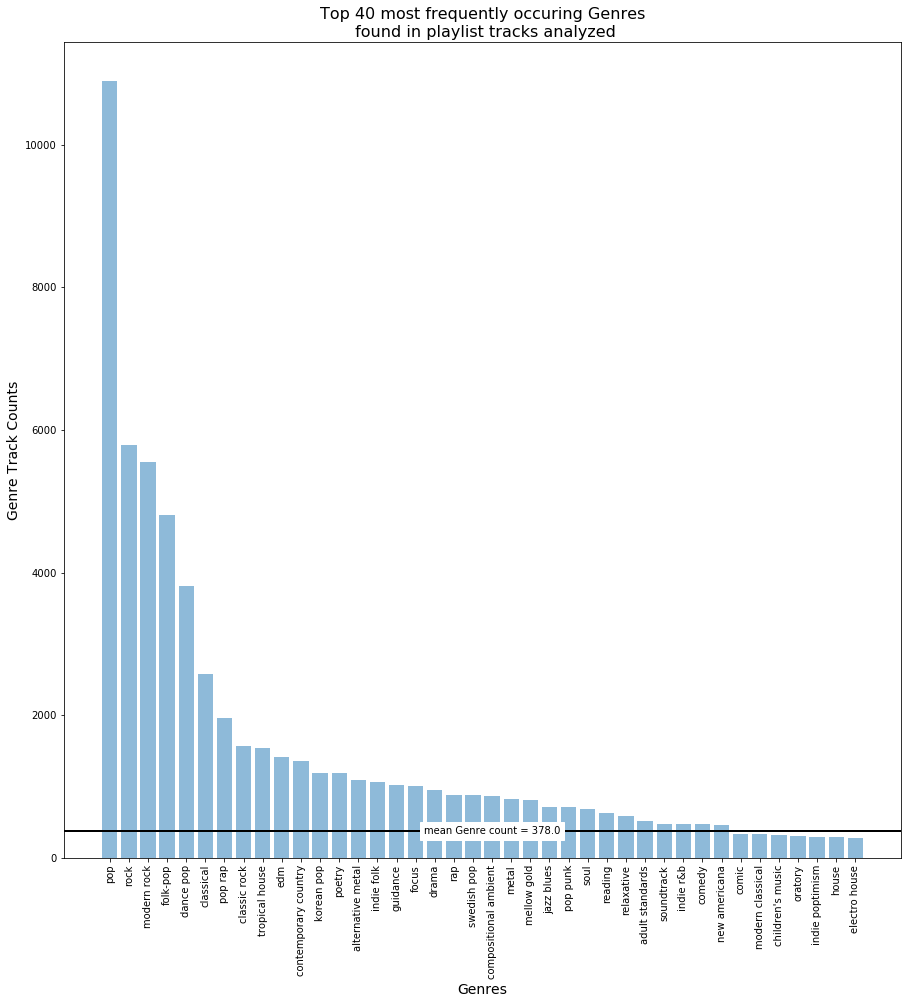

In [16]:
# EDA - Visualize Genres with most the most number of tracks tagged with that Genre
df_genres_sorted = df_genres.sort_values('num_tracks',ascending=False)
asd = df_genres_sorted.head(n=40)
mean_genre = np.round(np.mean(df_genres.num_tracks))
objects  = tuple(list(asd['genre']))
y_pos = np.arange(asd.shape[0])
performance = list(asd['num_tracks'])
plt.figure(figsize=(15,15))
plt.xticks(y_pos, objects, rotation='vertical')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.axhline(y = np.mean(df_genres.num_tracks), linewidth=2, color = 'k')
plt.text(20, np.mean(df_genres.num_tracks), 'mean Genre count = '+str(mean_genre), fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.title("Top 40 most frequently occuring Genres\n found in playlist tracks analyzed", fontsize = 16)
plt.ylabel("Genre Track Counts", fontsize = 14)
plt.xlabel("Genres", fontsize = 14)
plt.show()

####  Which Genres have more Explicit lyrics on average?  

We plotted the top 40 most Explicit Genres, considering only the Genres having a significant Track count, where significant is defined as a Genre having the mean number of Tracks (371) or more associated with it. =

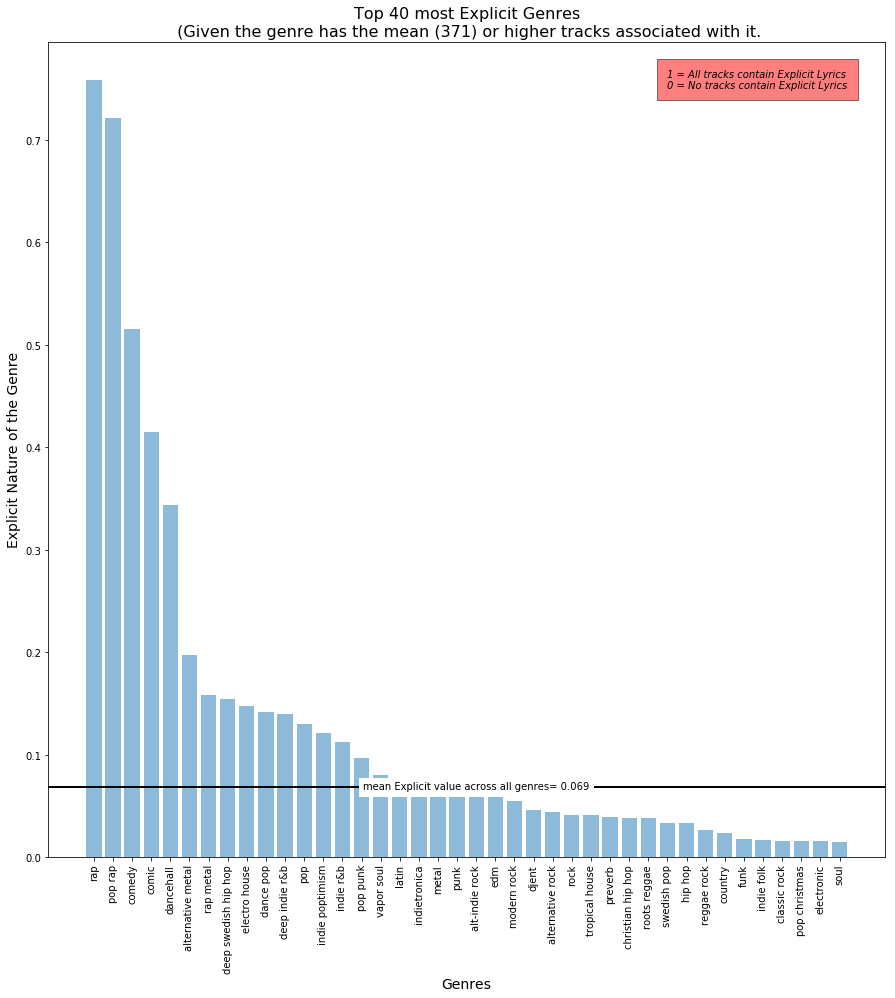

In [17]:
# EDA - Explore which Genres are more likely to have Explicit Lyrics.
# Most genres aren't explicit in nature based on mean value.
asd = df_genres[df_genres['num_tracks'] > 100].sort_values('mean_track_explicit',ascending=False).head(n=40)
mean_explicit = np.around(np.mean(df_genres.mean_track_explicit), decimals = 3)
objects  = tuple(list(asd['genre']))
y_pos = np.arange(asd.shape[0])
performance = list(asd['mean_track_explicit'])
plt.figure(figsize=(15,15))
plt.xticks(y_pos, objects, rotation='vertical')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.axhline(y = np.mean(df_genres.mean_track_explicit), linewidth=2, color = 'k')
plt.text(20, np.mean(df_genres.mean_track_explicit), 'mean Explicit value across all genres= '+str(mean_explicit), fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.title("Top 40 most Explicit Genres\n (Given the genre has the mean (371) or higher tracks associated with it.",  
          fontsize = 16)
plt.ylabel("Explicit Nature of the Genre", fontsize = 14)
plt.xlabel("Genres", fontsize = 14)
plt.text(30, 0.75, '1 = All tracks contain Explicit Lyrics\n0 = No tracks contain Explicit Lyrics', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
plt.show()

#### Are there any trends where similar genres have more explicit lyrics on average?  

In general, most Genre associated Tracks don't have Explicit lyrics, the average value being 0.059 (closer to 0).  'rap' and 'hip hop' (two closely related Genres) dominate the 20 positions with significantly larger 'Explicit' values than most genres.  Two comedy related genres also appear in the top 20.

#### Which genres have the most followers

In [18]:
df_genres.head()

,genre,num_playlists,num_tracks,mean_num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
0,hip hop,2,122,61.000000,0.032787,218843.385246,34.106557,19.408384,63,56.711111,12.560884,96,307989.325926,1.192077e+06,11708749,916835.074074,2.599938e+06,15505212,407740.000000
1,new americana,7,457,65.285714,0.004376,224923.177243,32.199125,15.949241,69,45.756930,14.132354,82,87769.445629,3.239972e+05,3769186,95365.501066,3.135611e+05,4046781,129014.285714
2,stomp and holler,1,44,44.000000,0.000000,230120.863636,13.500000,12.792931,42,34.468085,14.703960,64,7883.553191,1.147047e+04,71365,15321.042553,3.162628e+04,189817,524.000000
3,house,6,286,47.666667,0.010490,320506.513986,40.083916,14.806678,80,46.855505,12.274563,83,35995.305046,1.573927e+05,2615042,93901.410550,2.539814e+05,3214726,443851.166667
4,neo mellow,2,136,68.000000,0.007353,216206.992647,25.073529,18.326545,68,49.467153,19.089513,99,288057.211679,1.267501e+06,14120621,334828.759124,1.197501e+06,12275024,22291.500000


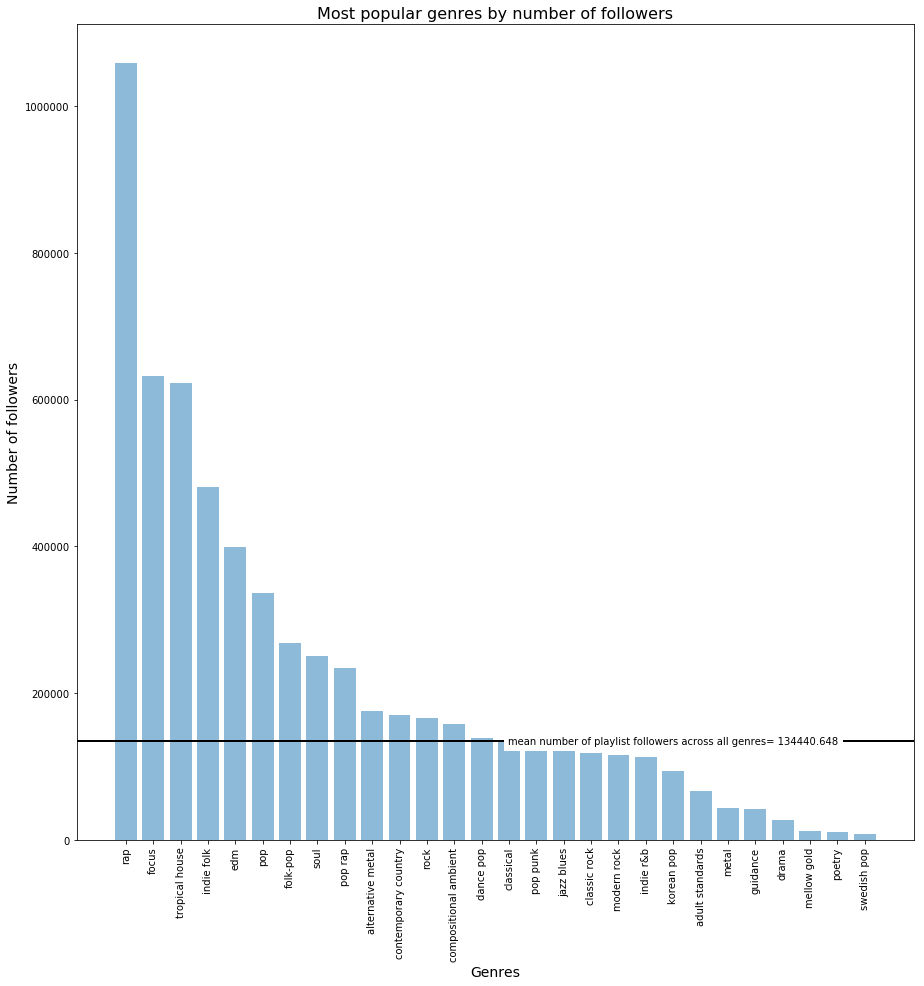

In [19]:
# EDA - Explore which Genres are more likely to have Explicit Lyrics.
# Most genres aren't explicit in nature based on mean value.
asd = df_genres[df_genres['num_playlists'] > 10].sort_values('followers',ascending=False).head(n=40)
mean_followers = np.around(np.mean(df_genres.followers), decimals = 3)
objects  = tuple(list(asd['genre']))
y_pos = np.arange(asd.shape[0])
performance = list(asd['followers'])
plt.figure(figsize=(15,15))
plt.xticks(y_pos, objects, rotation='vertical')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.axhline(y = np.mean(df_genres.followers), linewidth=2, color = 'k')
plt.text(20, np.mean(df_genres.followers), 'mean number of playlist followers across all genres= '+str(mean_followers), fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.title("Most popular genres by number of followers", fontsize = 16)
plt.ylabel("Number of followers", fontsize = 14)
plt.xlabel("Genres", fontsize = 14)
plt.show()

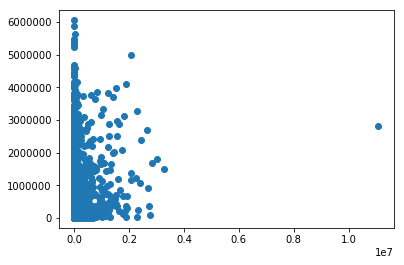

In [20]:
meanArtistFollowers = []
for playlist in playlists:
    artistFollowers = []
    for track in playlist.tracks:
        if track.artist1:
            artistFollowers.append(track.artist1.followers)
        if track.artist2:
            artistFollowers.append(track.artist2.followers)
        if track.artist3:
            artistFollowers.append(track.artist3.followers)
    meanArtistFollowers.append(np.mean(artistFollowers))
plt.scatter([playlist.followers for playlist in playlists], meanArtistFollowers)
plt.show()

# Clustering Genres By Co-Occurrence

In [27]:
#### The basicDistance Calculating functions

In [21]:
# Get a count of all genres as they occur in all data in the dataset
genresCount = Counter(getAllGenres())

# Get a list of all unique genres in the dataset, ordered by the frequency that they appear in
genres = genresByCount(getAllGenres())


# "Distance" function for calculating the similarity of genres, based on their co-occurence in playlists
# 0 indicates that the two genres never appear together. 1 indicates that they always appear together
def distance(genre1, genre2):
    if genre1 == genre2:
        return 0.0
    # A count measuring how often one genre or the other appears
    opportunities = 0.0
    # A count measuring how often one genre appears without the other. A "missed" opportunity
    missed = 0.0
    
    # The distance should be penalized less if an extremely popular genre, like 'pop'
    # appears without a very rare genre like 'icelandic fairy pop' (not a real genre)
    # Therefore, we need to figure out which genre is most and least popular
    mostPopular = genre2 if genres.index(genre1) > genres.index(genre2) else genre1
    leastPopular = genre1 if genres.index(genre1) > genres.index(genre2) else genre2
    
    # Weight the distance penalties by the relative occurences of the genres
    unpopular_missed_penalty = float(genresCount[leastPopular] / genresCount[mostPopular])
    popular_missed_penalty = np.reciprocal(unpopular_missed_penalty)
    
    for playlist in playlists:
        if leastPopular in playlist.genres or mostPopular in playlist.genres:
            if mostPopular not in playlist.genres:
                # The most least genre occurs, but the most popular one does not.
                # This is a larger penalty
                opportunities += popular_missed_penalty
                missed += popular_missed_penalty
            elif leastPopular not in playlist.genres:
                # The least popular genre occurs, but the most popular one does not.
                # This is a smaller penalty
                opportunities += unpopular_missed_penalty
                missed += unpopular_missed_penalty
            else:
                # They're both in it -- big win. 
                opportunities += 1
    retDist = float(missed / opportunities)
    if np.isnan(retDist):
        return 1.0
    return retDist


# Calculate the distance between two groups of genres by averaging 
def distance_between_groups(group1, group2, return_0_if_any_common_genres=False):
    if group1 == group2:
        return 0.0
    avgs = []
    for genre1 in group1:
        for genre2 in group2:
            if return_0_if_any_common_genres:
                if genre1 == genre2:
                    return 0.0
            avgs.append(distance(genre1, genre2))
    return np.mean(avgs)

In [22]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import FeatureAgglomeration


# Get a list of unique genres in no particular order
playlistGenres = []
for playlist in playlists:
    playlistGenres.append(playlist.mainGenre)
playlistGenres = list(set(playlistGenres))

distance_matrix = []
for genre1 in playlistGenres:
    row = []
    for genre2 in playlistGenres:
        row.append(distance(genre1, genre2))
    distance_matrix.append(row)

n_clusters = [5, 10, 15, 20, 25, 30]
print("Agglomerative clustering silhouette scores, by number of clusters")
for n in n_clusters:
    agglom = AgglomerativeClustering(n_clusters=n, affinity='precomputed', linkage='average')
    agglom.fit(distance_matrix)
    score = silhouette_score(distance_matrix, agglom.labels_, metric='precomputed')
    print(str(n)+" : "+str(score))

eps_vals = [.001, .001, .005, .0075, .01, .05, .075, .1, .12, .15, .2]
print("DBSCAN silhouette scores by eps value")
for eps_val in eps_vals:
    dbscan = DBSCAN(eps=eps_val, min_samples=1, metric='precomputed', algorithm='brute')
    dbscan.fit(distance_matrix)
    score = silhouette_score(distance_matrix, dbscan.labels_, metric='precomputed')
    print(str(eps_val)+" : "+str(score))
    

Agglomerative clustering silhouette scores, by number of clusters
5 : 0.0162759001076
10 : 0.0206161778854
15 : 0.0453774425288
20 : 0.065327904838
25 : 0.0739266001659
30 : 0.0945736823841
DBSCAN silhouette scores by eps value
0.001 : 0.030303030303
0.001 : 0.030303030303
0.005 : 0.030303030303
0.0075 : 0.030303030303
0.01 : 0.030303030303
0.05 : 0.0398727294824
0.075 : 0.0398727294824
0.1 : 0.0398727294824
0.12 : 0.0640611529832
0.15 : 0.0688216353369
0.2 : 0.0854054279767


In [23]:
from itertools import chain
from itertools import groupby
import networkx
from networkx.algorithms.components.connected import connected_components

# Turns the output of a clustering algorithm with groups and labels and returns a list of items
# Assumes that the items within each group is a list itself, and merges all of the lists together
def get_labeled_lists(labels, groups):
    labels_dict = dict()
    unsorted= []
    for i in range(len(labels)):
        if str(labels[i]) not in labels_dict:
            labels_dict[str(labels[i])] = []
        if str(labels[i]) == '-1':
            # Better luck with these guys next time... 
            # Add them as individual items to the return list
            unsorted.append(groups[i])
        else:
            labels_dict[str(labels[i])].extend(groups[i])
    return_groups = [value for key, value in labels_dict.items() if len(value) != 0]
    return_groups.extend(unsorted)
    return return_groups

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current

def group_lists(listOfList):
    G = to_graph(listOfList)
    component_list = list(connected_components(G))
    return [list(x) for x in component_list]

def match_groups(groups, eps, big_groups_limit=20, directly_compare=False):
    
    big_groups = []
    little_groups = []
    # We want to avoid groups that are too big. Pull the larger groups aside
    # and only cluster the smaller groups
    for group in groups:
        if len(group) > big_groups_limit:
            big_groups.append(group)
        else:
            little_groups.append(group)

    if directly_compare:
        pairsToCombine = []
        for i in range(len(little_groups)):
            row = []
            for j in range(i, len(little_groups)):
                if i != j:
                    if  distance_between_groups(little_groups[i], little_groups[j]) < eps:
                        pairsToCombine.append([i, j])
        indexGroupsToCombine = group_lists(pairsToCombine)
        
        print(indexGroupsToCombine)
        combinedIndexes = []
        combined = []
        for indexesList in indexGroupsToCombine:
            tmp = []
            for index in indexesList:
                tmp.extend(little_groups[index])
                combinedIndexes.append(index)
            combined.append(tmp)
            
        print(combinedIndexes)
        # Add all that weren't grouped
        for i in range(len(little_groups)):
            if i not in combinedIndexes:
                combined.append(little_groups[i])
        combined.extend(big_groups)
        return combined
    else:
                    
        distances = []
        for genre_group1 in little_groups:
            row = []
            for genre_group2 in little_groups:
                row.append(distance_between_groups(genre_group1, genre_group2))
            distances.append(row)
        
        dbscan = DBSCAN(eps=eps, min_samples=1, metric='precomputed', algorithm='auto')
        dbscan.fit(distances)
        groups = get_labeled_lists(dbscan.labels_, little_groups)
    
    groups.extend(big_groups)

    return groups



In [24]:
print(len(playlistGenres))

198


In [25]:
playlistGenres = list(set([playlist.mainGenre for playlist in playlists]))

distance_matrix = []
for genre1 in playlistGenres:
    row = []
    for genre2 in playlistGenres:
        row.append(distance(genre1, genre2))
    distance_matrix.append(row)

# DB scan mostly does a good job, but splits some groups into too large of a category
# and others cannot be sufficiently grouped
print("PASS 1")
dbscan = DBSCAN(eps=.5, min_samples=1, metric='precomputed', algorithm='brute')
dbscan.fit(distance_matrix)

label_dict = defaultdict(list)
unsorted = []
print(dbscan.labels_)
for i in range(len(dbscan.labels_)):
    label_dict[str(dbscan.labels_[i])].append(playlistGenres[i])
    if dbscan.labels_[i] == -1:
        unsorted.append([playlistGenres[i]])
groups = [value for key, value in label_dict.items()]
groups.extend(unsorted)

print(len(groups))
print(len(groups))
for group in groups:
    print(group)


PASS 1
[  0   1   2   3   4   5   6   7   8   9  10  11  12   0  13  14   8  15
  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  31  34  35  10  36  37  38  39  40  41  42  43  44  45  46  47  48  15
  36  49  50  51  52  53  54  55  56  57  58  59  60  17  61  62  51  63
  64  65  49   0  66  67  68  24  69  70  71  72  73  74  75  76  64  77
  78  79   3  80  81  82  54  83  84  83  85  86  87  88  89  90  91  45
  92   4  10  93  94  95  96  83  97  98  99  73  75 100 101 102   6 103
 104  64 105  51 106 107 108 109 110 111 112 113 114  91 115  58 116 117
 118  57 119 120 121 122 123 124 125 126 127   6 128 129  63 130 131 132
 133   6  64 134 135 136  51 137 138   6 139 140 141 142  15  73 143 144
 145 146 122 147   0 148  34  51 149 150 151 152   5 120 153  39 154  79]
155
155
['alt-indie rock']
['free jazz']
['theme']
['korean pop']
['punk']
['stomp and holler']
['trip hop']
['country christmas']
['house', 'tech house']
['fourth world']
['gothic metal']


In [26]:
print("PASS 2")
print(len(groups))
groups2 = match_groups(groups, .7)
print("LEN GROUPS 2:")
print(len(groups2))
for group in groups2:
    print(group)



PASS 2
155
LEN GROUPS 2:
136
['classify', 'fingerstyle']
['pop christmas']
['swedish punk']
['preverb']
['theme']
['dance pop', 'edm', 'tropical house', 'kompa', 'pop']
['korean pop']
['wind ensemble']
['compositional ambient', 'christian relaxative', 'relaxative', 'focus']
['alternative metal']
['indie pop']
['metal']
['world']
['swedish idol pop', 'deep swedish hip hop', 'swedish indie rock', 'swedish pop']
['drum and bass']
['gospel', 'christian hip hop']
['german hip hop', 'deep german hip hop']
['bass music']
['finnish dance pop']
['scorecore', 'soundtrack']
['indie folk', 'modern rock', 'folk-pop']
['modern blues']
['cabaret', 'chanson']
['strut']
['progressive house', 'trance']
['post rock']
['filter house']
['post-screamo', 'rap metal']
['progressive bluegrass', 'bluegrass']
['gypsy jazz']
['movie tunes']
['viking metal']
['grime']
['beats', 'electronic trap']
['reggaeton', 'latin']
['deep hardstyle']
['black metal', 'pagan black metal']
['tracestep', 'antiviral pop']
['alterna

In [28]:
groups3 = match_groups(groups2, .8, 10, True)
print("LEN GROUPS 3:")
print(len(groups2))
for group in groups3:
    print(group)
print(len(groups3))

[[134, 95], [110, 7], [9, 11, 69, 31], [19, 119], [99, 21], [26, 68], [90, 27], [32, 41, 66], [58, 43], [59, 45], [107, 46], [116, 54, 47], [49, 97], [64, 120, 109], [67, 117], [72, 127], [124, 76], [85, 77], [118, 79], [88, 122], [96, 125]]
[134, 95, 110, 7, 9, 11, 69, 31, 19, 119, 99, 21, 26, 68, 90, 27, 32, 41, 66, 58, 43, 59, 45, 107, 46, 116, 54, 47, 49, 97, 64, 120, 109, 67, 117, 72, 127, 124, 76, 85, 77, 118, 79, 88, 122, 96, 125]
LEN GROUPS 3:
136
['brill building pop', 'rock-and-roll']
['classical', 'brass ensemble', 'wind ensemble']
['alternative metal', 'metal', 'technical death metal', 'death metal', 'viking metal']
['scorecore', 'soundtrack', 'video game music']
['blues-rock', 'modern blues']
['filter house', 'deep danish pop']
['metalcore', 'post-screamo', 'rap metal']
['grime', 'deep melodic euro house', 'house', 'tech house']
['fluxwork', 'float house']
['mellow gold', 'rock', 'classic rock']
['urban contemporary', 'r&b']
['afrobeats', 'deep dutch hip hop', 'trap franca

In [29]:
groups4 = match_groups(groups3, .9, 10, True)
print("LEN GROUPS 3:")
print(len(groups3))
for group in groups4:
    print(group)
print(len(groups4))

[[67, 79], [97, 68, 60], [26, 36, 86], [56, 54, 70], [91, 7], [73, 21], [74, 53], [29, 109, 99, 12, 37], [89, 82, 50, 78], [84, 46], [98, 22], [96, 18]]
[67, 79, 97, 68, 60, 26, 36, 86, 56, 54, 70, 91, 7, 73, 21, 74, 53, 29, 109, 99, 12, 37, 89, 82, 50, 78, 84, 46, 98, 22, 96, 18]
LEN GROUPS 3:
110
['folk rock', 'motown']
['indie jazz', 'fourth world', 'contemporary jazz', 'trip hop', 'nu jazz', 'electronic']
['dance pop', 'edm', 'tropical house', 'kompa', 'pop', 'finnish dance pop', 'italian arena pop']
['drama', 'judaica', 'comic', 'comedy', 'reading', 'poetry', 'hollywood']
['deep house', 'grime', 'deep melodic euro house', 'house', 'tech house']
['classical guitar', 'classify', 'fingerstyle']
['dancehall', 'reggae rock', 'roots reggae', 'reggae']
['indie pop', 'norwegian indie', 'singer-songwriter', 'stomp and holler', 'new americana', 'indie folk', 'modern rock', 'folk-pop']
['vapor twitch', 'deep indie r&b', 'chillhop', 'alternative hip hop', 'indie r&b', 'footwork']
['tropical',

In [30]:
groups5 = match_groups(groups4, .95, 10, True)
print("LEN GROUPS 5:")
print(len(groups5))
for group in groups5:
    print(group)

[[0, 65, 67, 11, 12, 79, 16, 80, 81, 20], [2, 70, 39, 42, 49, 22, 55], [72, 36, 86], [88, 75], [76, 77, 14, 18, 50, 25], [24, 13], [34, 27, 44, 37], [28, 53], [56, 31], [64, 47], [61, 46]]
[0, 65, 67, 11, 12, 79, 16, 80, 81, 20, 2, 70, 39, 42, 49, 22, 55, 72, 36, 86, 88, 75, 76, 77, 14, 18, 50, 25, 24, 13, 34, 27, 44, 37, 28, 53, 56, 31, 64, 47, 61, 46]
LEN GROUPS 5:
59
['folk rock', 'motown', 'funk', 'deep funk', 'new orleans blues', 'alternative rock', 'disco', 'soul', 'soul christmas', 'classic funk rock', 'brill building pop', 'rock-and-roll', 'garage rock', 'blues-rock', 'modern blues', 'swing', 'new wave pop', 'mellow gold', 'rock', 'classic rock']
['dance pop', 'edm', 'tropical house', 'kompa', 'pop', 'finnish dance pop', 'italian arena pop', 'underground hip hop', 'german hip hop', 'deep german hip hop', 'strut', 'deep hardstyle', 'afrobeats', 'deep dutch hip hop', 'trap francais', 'hip hop', 'rap', 'pop rap', 'nerdcore']
['europop', 'swedish idol pop', 'deep swedish hip hop', 

In [31]:
groups6 = match_groups(groups5, .975, 10, True)
print("LEN GROUPS 6:")
print(len(groups6))
for group in groups6:
    print(group)

[[32, 13], [33, 29, 39, 14, 23], [9, 34, 11, 36], [27, 21]]
[32, 13, 33, 29, 39, 14, 23, 9, 34, 11, 36, 27, 21]
LEN GROUPS 6:
50
['progressive bluegrass', 'bluegrass', 'indie pop', 'norwegian indie', 'singer-songwriter', 'stomp and holler', 'new americana', 'indie folk', 'modern rock', 'folk-pop']
['beats', 'electronic trap', 'bass music', 'destroy techno', 'indietronica', 'electro house', 'vapor twitch', 'deep indie r&b', 'chillhop', 'alternative hip hop', 'indie r&b', 'footwork', 'vapor soul', 'indie poptimism']
['drama', 'judaica', 'comic', 'comedy', 'reading', 'poetry', 'hollywood', 'tracestep', 'antiviral pop', 'classical guitar', 'classify', 'fingerstyle', 'oratory']
['world', 'samba', 'bossa nova', 'swedish jazz']
['europop', 'swedish idol pop', 'deep swedish hip hop', 'swedish indie rock', 'swedish pop', 'deep swedish indie pop']
['contemporary country', 'country', 'country christmas', 'outlaw country']
['early music', 'choral', 'classical', 'brass ensemble', 'wind ensemble']
[

In [1041]:
# No change in group size. We've reached the point where the stragglers do not have genres in common
groups7 = match_groups(groups6, .9999, 2, True)
print("LEN GROUPS 7:")
print(len(groups7))
for group in groups7:
    print(group)

[[16, 1], [4, 23]]
[16, 1, 4, 23]
LEN GROUPS 7:
45
['electronic trap', 'beats', 'preverb', 'indie psych-rock']
['blues-rock', 'modern blues', 'psychobilly']
['gypsy jazz', 'jazz fusion']
['deep swedish hip hop', 'deep swedish indie pop']
['urban contemporary', 'r&b']
['gospel']
['spanish reggae']
['smooth jazz']
['bluegrass', 'progressive bluegrass']
['drone folk']
['christian hip hop']
['indian pop']
['tracestep']
['new wave pop']
['barnmusik', 'vintage swedish pop']
['swedish punk']
['hardcore techno']
['guidance']
['psychedelic rock']
['viking metal']
['theme']
['korean pop']
['j-rock', 'j-pop']
['hawaiian']
['progressive house']
['celtic', 'irish folk']
['stoner rock']
['swedish pop', 'swedish indie rock', 'europop', 'latin alternative', 'world', 'samba', 'swedish jazz', 'bossa nova', 'contemporary jazz', 'fourth world']
['post-screamo', 'rap metal', 'metalcore', 'progressive deathcore', 'pop punk', 'punk']
['roots reggae', 'reggae', 'reggae rock', 'deep indie r&b', 'fluxwork', 'am

In [33]:
genreGroups = groups6

# Regression

In [34]:
# Genre groups to try: 
#     groups contains 46 genre groups
#     groups2 contains 101 genre groups
#groups  = [['environmental', 'healing', 'native american', 'sleep', 'environmental', 'healing', 'sleep', 'healing', 'native american'], ['stoner rock'], ['guidance'], ['beats', 'electronic trap'], ['new wave pop'], ['classical guitar', 'classify', 'fingerstyle', 'drum and bass', 'focus', 'compositional ambient', 'modern classical', 'christian relaxative', 'relaxative', 'minimal', 'post rock'], ['country christmas', 'outlaw country', 'dancehall', 'reggae', 'reggae rock', 'roots reggae', 'singer-songwriter'], ['swedish punk'], ['moombahton', 'tropical', 'latin', 'reggaeton'], ['progressive deathcore', 'metalcore', 'rap metal', 'post-screamo'], ['irish folk', 'celtic'], ['theme'], ['trance', 'progressive house'], ['free jazz', 'hollywood', 'movie tunes', 'nursery', "children's christmas", "children's music", 'oratory', 'scorecore', 'soundtrack', 'video game music', 'comic', 'drama', 'comedy', 'reading', 'antiviral pop', 'judaica', 'poetry'], ['hawaiian'], ['r&b', 'urban contemporary'], ['drone folk'], ['ambient idm', 'fluxwork', 'float house'], ['motown', 'swing', 'brill building pop', 'folk rock', 'vocal jazz', 'rock-and-roll', 'adult standards', 'jazz blues', 'cool jazz'], ['bossa nova', 'world'], ['smooth jazz'], ['psychobilly'], ['tech house', 'house', 'grime', 'deep melodic euro house', 'deep house'], ['afrobeats', 'deep dutch hip hop', 'trap francais'], ['indian pop'], ['christian hip hop'], ['christian alternative rock', 'christian music', 'contemporary country', 'country', 'pop christmas', 'neo mellow', 'redneck'], ['bluegrass', 'progressive bluegrass'], ['j-pop', 'j-rock'], ['contemporary jazz', 'fourth world', 'swedish jazz', 'electronic', 'indie jazz', 'nu jazz', 'trip hop'], ['barnmusik', 'vintage swedish pop'], ['neo-singer-songwriter'], ['hardcore techno'], ['early music', 'classical', 'choral', 'wind ensemble', 'brass ensemble'], ['underground hip hop'], ['rock en espanol'], ['djent', 'gothic metal', 'progressive metal', 'speed metal'], ['disco', 'blues-rock', 'soul', 'funk', 'classic funk rock', 'soul christmas', 'deep funk', 'modern blues', 'new orleans blues'], ['chanson'], ['psychedelic rock'], ['alt-indie rock', 'alternative emo', 'filter house', 'deep danish pop', 'danish pop', 'indie psych-rock', 'preverb', 'indie rock'], ['chillhop', 'deep indie r&b', 'footwork', 'indie r&b', 'indie poptimism', 'vapor soul'], ['gypsy jazz', 'jazz fusion'], ['deep swedish indie pop', 'swedish idol pop', 'swedish pop', 'swedish indie rock', 'deep swedish hip hop', 'swedish indie pop', 'europop'], ['alternative metal', 'black metal', 'punk', 'rock', 'viking metal', 'pagan black metal', 'death metal', 'modern rock', 'classic rock', 'folk-pop', 'pop punk', 'mellow gold', 'indie folk', 'new americana', 'norwegian indie', 'technical death metal', 'metal', 'alternative rock', 'indie pop', 'stomp and holler'], ['tropical house', 'hip hop', 'strut', 'pop', 'italian arena pop', 'destroy techno', 'deep german hip hop', 'indietronica', 'finnish dance pop', 'electro house', 'kompa', 'gospel', 'korean pop', 'deep hardstyle', 'edm', 'nerdcore', 'rap', 'dance pop', 'pop rap']]
#groups2 = [['afrobeats', 'azonto', 'azontobeats'], ['world', 'afrobeat', 'mande pop'], ['irish country', 'irish folk', 'celtic', 'jig and reel'], ['screamo', 'post-screamo'], ['horror punk', 'psychobilly', 'rockabilly'], ['melodic death metal', 'viking metal', 'folk metal'], ['symphonic metal', 'power metal', 'gothic metal'], ['urban contemporary', 'r&b'], ['jazz blues', 'soul blues', 'memphis blues'], ['christian hip hop', 'christian uplift', 'gothic rock'], ['christian music', 'ccm', 'christian alternative rock'], ['new orleans blues', 'funk', 'deep funk'], ['indian pop', 'filmi', 'desi'], ['french indie pop', 'french pop', 'ye ye', 'cabaret', 'chanson'], ['underground pop rap', 'indie rockism', 'indie poptimism'], ['orchestral'], ['soul', 'disco', 'classic funk rock'], ['show tunes', 'post-teen pop', 'broadway', 'hollywood', 'new age'], ['britpop'], ['jazz', 'cool jazz', 'avant-garde jazz'], ['contemporary jazz', 'fourth world', 'dark jazz'], ['poetry', 'musique pour enfants', 'british folk', 'experimental'], ['progressive metal', 'neo classical metal', 'djent', 'jazz metal'], ['dance rock', 'new wave pop'], ['viral pop'], ['psychedelic rock'], ['pop christmas'], ['outlaw country', 'country christmas'], ['motivation', 'guidance'], ['nursery', "children's music", "children's christmas"], ['latin pop', 'trap latino', 'reggaeton', 'tropical', 'latin jazz', 'latin'], ['future funk', 'vaporwave', 'spanish reggae'], ['shimmer pop', 'alternative hip hop'], ['ukulele', 'hawaiian', 'world christmas'], ['trap francais', 'francoton'], ['pagan black metal', 'black metal', 'voidgaze'], ['rock en espanol', 'latin alternative'], ['contemporary country', 'lift kit', 'redneck', 'country', 'country road'], ['sleep', 'environmental'], ['art rock'], ['progressive house', 'progressive uplifting trance', 'trance'], ['indie pop'], ['j-pop', 'japanese r&b', 'j-dance', 'j-rock'], ['bass music'], ['vintage swedish pop', 'barnmusik'], ['pop punk', 'punk', 'anthem emo', 'emo', 'ska'], ['deep euro house', 'deep melodic euro house', 'groove room'], ['swedish alternative rock', 'danspunk', 'swedish punk'], ['vocal house', 'disco house', 'outsider house', 'deep house', 'float house'], ['danish pop', 'deep danish pop', 'garage rock'], ['indie anthem-folk'], ['swing', 'traditional swing', 'vintage jazz', 'christmas', 'jump blues'], ['hardcore techno'], ['meditation', 'healing'], ['modern blues', 'country blues', 'blues-rock'], ['technical death metal', 'death metal', 'brutal death metal'], ['doo-wop', 'brill building pop', 'rock-and-roll'], ['alternative emo'], ['gypsy jazz', 'jazz fusion', 'jazz funk', 'jazz bass'], ['swedish pop', 'europop', 'classic swedish pop', 'eurovision', 'swedish eurodance', 'swedish folk pop'], ['swedish indie pop', 'swedish indie rock', 'folkmusik', 'deep swedish indie pop'], ['movie tunes'], ['free jazz'], ['indie jazz', 'contemporary post-bop'], ['praise', 'christian christmas', 'gospel'], ['alternative rock'], ['chillhop'], ['mellow gold', 'soft rock'], ['roots rock'], ['pop rock'], ['irish rock'], ['uk garage'], ['hard rock'], ['native american'], ['neo mellow'], ['deep latin alternative'], ['traditional folk'], ['moombahton'], ['theme'], ['underground hip hop'], ['vapor soul'], ['oratory'], ['folk rock'], ['motown'], ['soul christmas'], ['album rock'], ['classic rock'], ['swedish jazz', 'adult standards', 'samba', 'deep swedish hip hop', 'swedish hip hop', 'swedish idol pop', 'bossa nova', 'vocal jazz'], ['reading', 'polish indie', 'antiviral pop', 'drama', 'skate punk', 'comic', 'comedy rock', 'deep comedy', 'hoerspiel', 'comedy', 'otacore', 'judaica', 'deep italo disco'], ['compositional ambient', 'video game music', 'soundtrack', 'deep chiptune', 'focus', 'bow pop', 'retro electro', 'drift', 'scorecore', 'relaxative', 'christian relaxative', 'psychill'], ['modern rock', 'k-indie', 'hip house', 'british alternative rock', 'norwegian indie', 'deep australian indie', 'indie folk', 'folk-pop', 'indie rock', 'finnish pop', 'deep dutch hip hop', 'strut', 'bluegrass', 'k-pop', 'mandopop', 'dance pop', 'classic icelandic pop', 'korean pop', 'folk', 'italian arena pop', 'rock', 'italian pop', 'alt-indie rock', 'finnish dance pop', 'pop', 'german hip hop', 'progressive bluegrass', 'french indietronica', 'singer-songwriter', 'neo-psychedelic', 'chamber pop', 'jam band', 'deep german hip hop', 'turkish pop'], ['nerdcore', 'rap', 'west coast trap', 'hip hop', 'pop rap', 'southern hip hop', 'detroit hip hop'], ['classify', 'deep big room', 'complextro', 'beats', 'hardstyle', 'liquid funk', 'jazz christmas', 'edm', 'tracestep', 'trap music', 'fingerstyle', 'indietronica', 'bass trap', 'chillstep', 'smooth jazz', 'deep hardstyle', 'destroy techno', 'brostep', 'electro house', 'deep tropical house', 'deep smooth jazz', 'kompa', 'electronic trap', 'tropical house', 'vapor twitch', 'drum and bass'], ['grime', 'deep groove house', 'microhouse', 'house', 'tech house', 'minimal techno', 'funky tech house'], ['post-grunge', 'metalcore', 'alternative metal', 'progressive deathcore', 'nu metal', 'speed metal', 'death core', 'rap metal', 'metal', 'groove metal', 'metropopolis', 'hardcore'], ['filter house', 'abstract hip hop', 'electro swing', 'chillwave', 'acid jazz', 'electronic', 'alternative dance', 'nu jazz', 'trip hop'], ['stomp and holler', 'neo-singer-songwriter', 'new americana', 'garage psych', 'indie punk', 'deep new americana', 'freak folk', 'drone folk', 'indie psych-rock', 'preverb', 'new weird america'], ['minimal', 'baroque', 'avant-garde', 'modern performance', 'serialism', 'composition d', 'wind ensemble', 'modern classical', 'opera', 'classical piano', 'brazilian composition', 'violin', 'romantic', 'classical', 'brass ensemble', 'choral', 'acousmatic', 'classical performance', 'early music', 'classical christmas', 'brass band', 'harpsichord', 'classical guitar', 'early music ensemble', 'canzone napoletana'], ['reggae fusion', 'rock steady', 'dub', 'riddim', 'dancehall', 'reggae rock', 'roots reggae', 'reggae'], ['avantgarde metal', 'psychedelic doom', 'nu gaze', 'stoner rock', 'post rock', 'post-metal', 'dream pop'], ['escape room', 'fluxwork', 'footwork', 'deep indie r&b', 'indie r&b', 'canadian pop', 'ambient idm']]

def playlistToGenreGroup(playlist):
    for i in range(len(genreGroups)):
        if playlist.mainGenre in groups6[i]:
            # Return groups index
            return i
    print("NOT FOUND: "+playlist.mainGenre)

def getTrackSimilarityScore(playlist):
    # Compute track similiarity score for a playlist defined as:
    #  (number of tracks in most popular genre group) / (all tracks)
    numGenreTracks = 0
    allTracks = 0
    # collect all genres associated with a playlist's tracks
    for track in playlist.tracks:
        genres = []
        if track.artist1 and track.artist1.genres:
            genres.extend(track.artist1.genres)
        if track.artist2 and track.artist2.genres:
            genres.extend(track.artist2.genres)
        if track.artist3 and track.artist3.genres:
            genres.extend(track.artist3.genres)
        # find the most occuring genre --> gCount[0]
        gCount = genresByCount(genres)
        # Is the track in most popular genre group?
        if gCount and playlist.genreGroup:
            if gCount[0] in groups[playlist.genreGroup]:
                numGenreTracks += 1
        allTracks += 1
    return numGenreTracks/allTracks

In [35]:
for playlist in playlists:
    playlist.genreGroup = playlistToGenreGroup(playlist)
    playlist.similarity = getTrackSimilarityScore(playlist)

In [47]:
playlistRows = []
for playlist in playlists:
    row = flattenPlaylist(playlist)
    row.insert(0, playlist.similarity)
    row.insert(0, playlist.genreGroup)
    row.insert(0, playlist.name)
    playlistRows.append(row)
headers = ['playlist_name', 'playlist_genre_group', 'track_similarity','num_tracks', 'mean_track_explicit', 'mean_track_popularities', 'mean_track_duration', 'std_track_popularities', 'max_track_popularities', 'mean_artist_popularities', 'std_artist_popularities', 'max_artist_popularities','mean_artist_followers', 'std_artist_followers', 'max_artist_followers', 'mean_artist_views', 'std_artist_views', 'max_artist_views', 'followers']

df_spotify = pd.DataFrame(playlistRows, columns = headers)

In [48]:
df_spotify['max_track_popularities']  = df['max_track_popularities'] 
df_spotify['max_artist_popularities'] = df['max_artist_popularities']

In [49]:
#  Q: How many NaNs are there in each column with missing data?
#  A:  None, so we won't impute
missing_columns = df_spotify.columns[df_spotify.isnull().any()]
df_spotify[missing_columns].isnull().sum()

Series([], dtype: float64)

In [50]:
#  Create dummy variables for "Playlist_Genre_Group"
df_spotify = pd.get_dummies(df_spotify, columns = ['playlist_genre_group'])

#  Remove the last dummy variable, 'Playlist_Genre_Group_45.0', since it's redundant 
remove_cols = ['playlist_genre_group_42.0']
df_spotify = df_spotify[df_spotify.columns.difference(remove_cols)]

# Put 'Playlist_Followers' column back to the end of the dataframe and
# 'Playlist_Name' column at the beginning of the dataframe
cols = list(df_spotify)
cols.insert(len(df_spotify) - 1, cols.pop(cols.index('followers')))
cols.insert(0, cols.pop(cols.index('playlist_name')))
df_spotify = df_spotify.reindex(columns= cols)

In [51]:
df_spotify.head()

,playlist_name,max_artist_followers,max_artist_popularities,max_artist_views,max_track_popularities,mean_artist_followers,mean_artist_popularities,mean_artist_views,mean_track_duration,mean_track_explicit,...,playlist_genre_group_6,playlist_genre_group_7,playlist_genre_group_8,playlist_genre_group_9,std_artist_followers,std_artist_popularities,std_artist_views,std_track_popularities,track_similarity,followers
0,b'The Refugee Playlist',5210412,89,4443917,67,5.641147e+05,61.848485,6.641898e+05,42.590909,0.090909,...,0,0,0,0,1.215937e+06,16.507338,9.247158e+05,19.106541,0.0,16084
1,b'Best of John Peel Sessions',4424637,84,23129006,43,2.297654e+05,50.064516,8.149162e+05,14.683333,0.000000,...,0,0,0,0,6.352567e+05,15.590393,2.916046e+06,9.319320,0.0,17864
2,b'New Noise',924636,78,2671926,76,9.389038e+04,53.240385,1.175892e+05,46.430000,0.070000,...,0,0,0,0,1.894456e+05,13.572098,2.852078e+05,12.488599,0.0,256892
3,b'Digging Now',3464127,100,5936516,76,3.087468e+05,64.408602,3.340995e+05,53.329545,0.090909,...,0,0,0,0,5.616157e+05,12.860907,7.646027e+05,13.680379,0.0,668423
4,b'Rock Solid',6157956,91,8068727,81,1.728723e+06,77.320000,1.716571e+06,66.880000,0.180000,...,0,0,0,0,1.431618e+06,5.880272,1.831774e+06,12.457351,0.0,944837


In [52]:
def split_data(df):
    # Split data into 25-75 train and test data
    np.random.seed(9001)
    msk = np.random.rand(len(df)) < 0.75
    data_train = df[msk]
    data_test = df[~msk]
    
    # set y data to just the last column, remove last column from the predictor sets
    ytrain = data_train.iloc[:,-1]
    Xtrain = data_train.drop(data_test.columns[len(data_test.columns)-1], axis=1)

    ytest = data_test.iloc[:,-1]
    Xtest = data_test.drop(data_test.columns[len(data_test.columns)-1], axis=1)
    return (ytrain, Xtrain, ytest, Xtest)

/Users/rmitchell/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


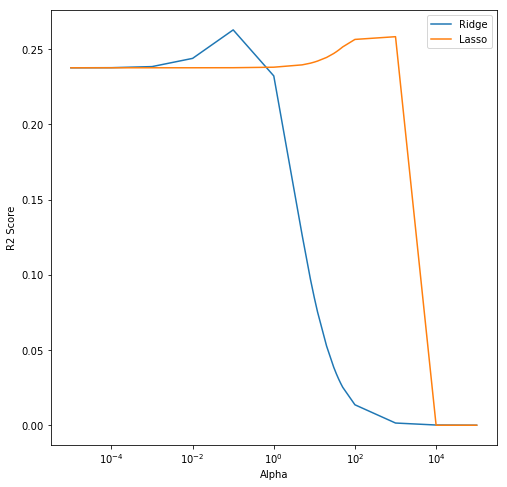

Best Lasso: 1000
Best Ridge: 0.1


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [53]:
#
#  Fit a regression model using using Lasso and RidgeCV 
#  and plot R^2 over alpha hyper parameters
#

# 'Playlist_Name'
#remove_cols = ['Playlist_Name']
#y = df_spotify['Playlist_Followers']
#df_spotify = df_spotify[df_spotify.columns.difference(remove_cols)]
#df_spotify.drop('Playlist_Followers', axis=1, inplace = True)

df_spotify.drop('playlist_name', axis=1, inplace = True)

# Get all four sets from split data function
ytrain, Xtrain, ytest, Xtest = split_data(df_spotify)

# Perform Lasso and Ridgeregression, then fit and score

# Added additional alpha values around 10 in order to get more precise data around this location
alphas = [.00001, .0001, .001, .01, .1, 1, 5, 8, 10, 12, 20, 30, 35, 40, 45, 50, 100, 1000, 10000, 100000]
r2s = {'ridge':[], 'lasso':[]}

for alpha in alphas:
    # Fit Lasso regression and add r2 results to r2 object
    # Note:  normalize=True yielded lower R^2
    lasso = Lasso(alpha=alpha, normalize=True, fit_intercept=True)
    lasso.fit(Xtrain, ytrain)
    lasso_preds = lasso.predict(Xtest)
    r2s['lasso'].append(r2_score(ytest, lasso_preds))
    
    # Fit Ridge regression add r2 results to r2 object
    ridge = Ridge(alpha=alpha, normalize=True, fit_intercept=True)
    ridge.fit(Xtrain, ytrain)
    ridge_preds = ridge.predict(Xtest)
    r2s['ridge'].append(r2_score(ytest, ridge_preds))
    
# Use a semilogx plot to display alpha values on a normalized scale
plt.figure(figsize=(8,8))
plt.semilogx(alphas, r2s['ridge'], label='Ridge')
plt.semilogx(alphas, r2s['lasso'], label='Lasso')
plt.ylabel("R2 Score")
plt.xlabel("Alpha")
plt.legend()
plt.show()

# Get the best r2 score found for both ridge and lasso
winningRidge = np.argmax(r2s['ridge'])
winningLasso = np.argmax(r2s['lasso'])
print("Best Lasso: "+str(alphas[winningLasso]))
print("Best Ridge: "+str(alphas[winningRidge]))

# Plot all r2 scores by their alpha value
lasso = Lasso(alpha=alphas[winningLasso], fit_intercept=True)
lasso.fit(Xtrain, ytrain)

ridge = Ridge(alpha=alphas[winningRidge], fit_intercept=True)
ridge.fit(Xtrain, ytrain)

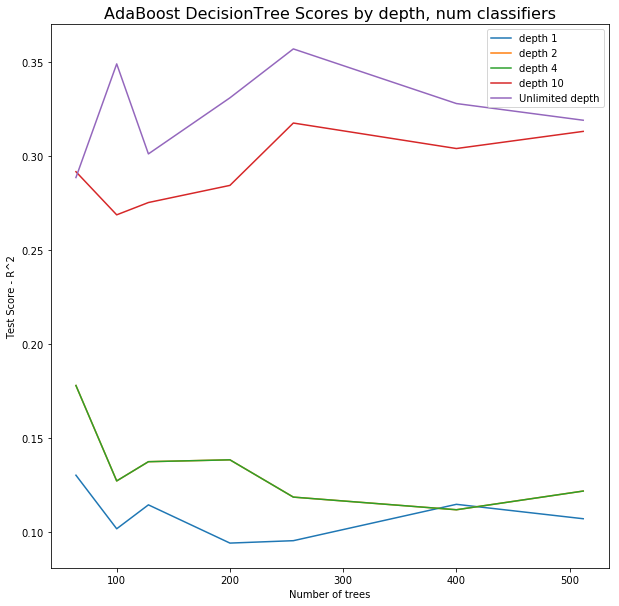

In [54]:
#
#  Fit a AdaBoost regression model using decision tree regressor
#
depths = [1, 2, 4, 10, None]
tree_nums = [64, 100, 128, 200, 256, 400, 512]

scores = []
for depth in depths:
    depth_scores = []
    for tree_num in tree_nums:
        dtc = DecisionTreeRegressor(max_depth=depth)
        ada = AdaBoostRegressor(dtc, learning_rate=0.05, n_estimators=tree_num)
        ada.fit(Xtrain, ytrain)
        ada_preds = ada.predict(Xtest)
        depth_scores.append(ada.score(Xtest, ytest))
    scores.append(depth_scores)

plt.figure(figsize = (10, 10))
plt.title('AdaBoost DecisionTree Scores by depth, num classifiers', fontsize = 16)
plt.xlabel('Number of trees')
plt.ylabel('Test Score - R^2')
plt.plot(tree_nums, scores[0], label='depth 1')
plt.plot(tree_nums, scores[1], label='depth 2')
plt.plot(tree_nums, scores[1], label='depth 4')
plt.plot(tree_nums, scores[2], label='depth 10')
plt.plot(tree_nums, scores[3], label='Unlimited depth')
plt.legend(loc='best')
plt.show()

In [55]:
def get_summary_df(X, y):
    ols = sm.OLS(y, X).fit()
    
    summary_data = ols.summary().tables[1].data
    header = summary_data.pop(0)
    header[0] = 'predictor'

    # We get the data as strings -- convert here. 
    for i in range(len(summary_data)):
        summary_data[i][1] = float(summary_data[i][1])
        summary_data[i][2] = float(summary_data[i][2])
        summary_data[i][3] = float(summary_data[i][3])
        summary_data[i][4] = float(summary_data[i][4])
        summary_data[i][5] = float(summary_data[i][5])
        summary_data[i][6] = float(summary_data[i][6])
        
    summary_df = pd.DataFrame(summary_data, columns=header)
    return summary_df

In [56]:
# Use entire dataframe
y = df_spotify['followers']
X = df_spotify.copy()
X.drop('followers', axis=1, inplace = True)
X_intercept = sm.add_constant(X)
summary_df = get_summary_df(X_intercept, y)
summary_df.sort_values('P>|t|', inplace=True)
summary_df.head(60)


,predictor,coef,std err,t,P>|t|,[0.025,0.975]
8,mean_track_duration,1.274000e+04,2143.938,5.943,0.000,8536.205,16900.000
65,std_track_popularities,-2.450000e+04,3923.634,-6.244,0.000,-32200.000,-16800.000
11,num_tracks,2.805162e+03,542.543,5.170,0.000,1740.841,3869.482
5,mean_artist_followers,-9.760000e-02,0.045,-2.176,0.030,-0.186,-0.010
60,playlist_genre_group_8,-2.673000e+05,132000.000,-2.025,0.043,-526000.000,-8414.023
18,playlist_genre_group_14,2.654000e+05,132000.000,2.012,0.044,6632.830,524000.000
0,const,-2.401000e+05,126000.000,-1.910,0.056,-487000.000,6479.981
29,playlist_genre_group_24,-2.090000e+05,114000.000,-1.829,0.068,-433000.000,15100.000
12,playlist_genre_group_0,9.770000e+04,56200.000,1.738,0.082,-12600.000,208000.000
49,playlist_genre_group_42,1.117000e+05,78700.000,1.419,0.156,-42700.000,266000.000


In [57]:
# Correlation heatmap
import seaborn as sns

#
#  We use Pandas' 'corr' method to compute pairwise correlation of column (defaults to Pearson)
#  Use which omits the unnormalized continuous predictors and the response variable
plt.figure(figsize = (15,15))
corr = df_spotify.corr() 

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())